In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeClassifier
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import cross_val_score
import collections
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn.tree as tree
import collections
%matplotlib inline

# Data Imputation and Dummy Creation

In [2]:
'''Read in our cleaned, aggregated data'''
plt.style.use('seaborn')
with open('aggregate_data.p', 'rb') as f:
    data = pickle.load(f)

#Impute missings with mean by category. Missings occur because the Million Songs Database only goes up until 2010.
category_means = data.groupby('category').mean()
tmp = data.join(category_means, rsuffix = '_category_mean', on = 'category')
means = tmp[[x+'_category_mean' for x in data.columns if x not in ['category', 'featured','num_tracks','num_followers']]]
means.columns = [x.split('_category_mean')[0] for x in means.columns]
#fill with mean by category and replace with overall mean if no mean by category
data = data.fillna(means)
data = data.fillna(data.mean())



# create dummies for category variable
def create_categorical_vars(data):
    categorical = ['category']
    dummies = {}
    for var in categorical:
        dummies[var] = pd.get_dummies(data[var], prefix = var)
        cols_to_keep = dummies[var].columns[0:len(dummies[var].columns)-1]
        data = data.join(dummies[var][cols_to_keep])
        data = data.drop(var, 1)
    return data
raw_data = data
data = create_categorical_vars(data)



#split into train / test to avoid cheating
np.random.seed(1234)
train_pct = .5
msk = np.random.uniform(0,1,len(data)) < train_pct
train = data.loc[msk, :]
test = data.loc[~msk, :]

In [3]:
'''We take a peek at our new training dataset'''
train.head()

,acousticness_max,acousticness_mean,acousticness_median,acousticness_min,acousticness_sd,danceability_max,danceability_mean,danceability_median,danceability_min,danceability_sd,...,category_pop,category_popculture,category_punk,category_reggae,category_rock,category_romance,category_sleep,category_soul,category_toplists,category_travel
37i9dQZF1DWSBRKlyNxSuy,0.985,0.904500,0.9440,0.623000,0.083575,0.540,0.442917,0.4635,0.2890,0.065845,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSIcimvN18p3,0.994,0.649742,0.7090,0.013200,0.277198,0.813,0.537625,0.5260,0.2190,0.133520,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSNNoRF9meHq,0.989,0.916120,0.9340,0.643000,0.069801,0.237,0.117402,0.1115,0.0611,0.042378,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSNmwgf7Nv11,0.979,0.490855,0.4705,0.000552,0.306968,0.831,0.527132,0.5335,0.1990,0.138828,...,0,0,0,0,0,0,0,0,0,0
37i9dQZF1DWSRoT7QRAibZ,0.937,0.736114,0.8045,0.055500,0.207173,0.897,0.560451,0.5460,0.3380,0.119142,...,0,0,0,0,0,0,0,0,0,0


# Create Classification Quintiles

In [5]:
'''We split our dependent var into quantiles for classification. We chose to use quintiles.'''
data['num_followers_quantile'] = pd.qcut(data['num_followers'], 5, labels=False)
quantiles = data['num_followers_quantile']

y_train = train['num_followers'].astype(float)
y_test = test['num_followers'].astype(float)


y_train_class = pd.concat([y_train, quantiles], axis=1, join_axes=[y_train.index]).drop('num_followers', axis = 1).values.ravel()
y_test_class = pd.concat([y_test, quantiles], axis=1, join_axes=[y_test.index]).drop('num_followers', axis = 1).values.ravel()

y_train_class_by_cat = raw_data.groupby('category')['num_followers'].apply(lambda x: pd.qcut(x, 3, labels = False)).loc[msk]
y_test_class_by_cat = raw_data.groupby('category')['num_followers'].apply(lambda x: pd.qcut(x, 3, labels = False)).loc[~msk]


# Standardize

In [8]:
'''Standardize numeric features'''
to_x_train = train[[x for x in train.columns if x != 'num_followers']]
to_x_test = test[[x for x in test.columns if x != 'num_followers']]

#Define continuous vars
continuous_variables = [x for x in to_x_train.columns if 'category' not in x and x != 'available_markets_max' and x != 'featured']
non_continuous_variables = [x for x in to_x_train.columns if 'category' in x]

#standardize data
def standardize_data(data, train):
        return (data - train.mean()) / train.std()


x_train_cont = standardize_data(to_x_train[continuous_variables], to_x_train[continuous_variables])
x_test_cont = standardize_data(to_x_test[continuous_variables], to_x_train[continuous_variables])

#merge back on non-continuous variables
x_train_std = x_train_cont.join(to_x_train[non_continuous_variables])
x_test_std = x_test_cont.join(to_x_test[non_continuous_variables])

x_train_std2 = x_train_std.join(to_x_train['available_markets_max'])
x_test_std2 = x_test_std.join(to_x_test['available_markets_max'])

x_train_std3 = x_train_std2.join(to_x_train['featured'])
x_test_std3 = x_test_std2.join(to_x_test['featured'])

x_train_class = sm.tools.add_constant(x_train_std3, has_constant = 'add')
x_test_class = sm.tools.add_constant(x_test_std3, has_constant = 'add')

In [9]:
'''calculate classification accuracy'''
def calculate_cr(classifications, y):
    correct = classifications == y
    cr = correct.sum()/len(correct)
    return cr

# Baseline Model

In [10]:
'''Begin with logistic models as baseline
Multinomial Logistic'''
logistic_regression_mn = LogisticRegressionCV(Cs=10, multi_class='multinomial').fit(x_train_class, y_train_class)
logistic_classifications_train_mn = logistic_regression_mn.predict(x_train_class)
logistic_classifications_test_mn = logistic_regression_mn.predict(x_test_class)

print("Multinomial Logistic Regression")
print("\tTrain CR:", str(calculate_cr(logistic_classifications_train_mn, y_train_class)))
print("\tTest CR:", str(calculate_cr(logistic_classifications_test_mn, y_test_class)))

#OvR Logistic Reg
logistic_regression_ovr = LogisticRegressionCV(Cs=10, multi_class='ovr').fit(x_train_class, y_train_class)
logistic_classifications_train_ovr = logistic_regression_ovr.predict(x_train_class)
logistic_classifications_test_ovr = logistic_regression_ovr.predict(x_test_class)

print("OvR Logistic Regression")
print("\tTrain CR:", str(calculate_cr(logistic_classifications_train_ovr, y_train_class)))
print("\tTest CR:", str(calculate_cr(logistic_classifications_test_ovr, y_test_class)))


Multinomial Logistic Regression
	Train CR: 0.706586826347
	Test CR: 0.355555555556
OvR Logistic Regression
	Train CR: 0.494011976048
	Test CR: 0.363888888889


# Additional Models - Across Categories
## Decision Tree

In [11]:
'''Decision Tree with CV to pick max depth'''
param_grid = {'max_depth' : range(1,30)}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid, cv = 5, refit = True)
clf.fit(x_train_class, y_train_class)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['max_depth']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class)*100)[0:5]))


Cross-Validated Max Depth: 4
Avg Cross-Validation Accuracy at Max: 33.53%
Test Accuracy: 34.72%


## Random Forest

In [13]:
'''Random Forest with CV to pick max depth and Number of Trees'''
param_grid = {'n_estimators' : [2**i for i in [1,2,3,4,5,6,7,8, 9, 10]],
              'max_depth' : [1,2,3,4,5,6,7,8]}
clf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5, refit = True, n_jobs = 4)
clf.fit(x_train_class, y_train_class)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['max_depth']))
print('Cross-Validated Num Trees: {x}'.format(x = clf.best_params_['n_estimators']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class)*100)[0:5]))

Cross-Validated Max Depth: 6
Cross-Validated Num Trees: 512
Avg Cross-Validation Accuracy at Max: 41.01%
Test Accuracy: 37.22%


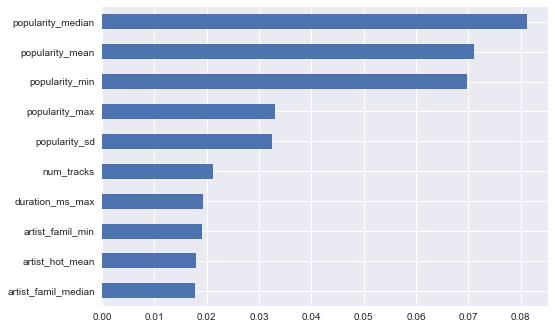

In [27]:
''' Top 10 most important features based on RF (as expected, popularity is important)'''
feature_importance = pd.Series(clf.best_estimator_.feature_importances_, index = x_train_class.columns)
feature_importance.sort_values(ascending = False).head(10).sort_values(ascending = True).plot('barh')

## AdaBoosted Decision Trees

In [155]:
'''AdaBoost with CV to pick max depth and number of trees'''
learning_rate = .05

param_grid = {'n_estimators' : [2**i for i in [1,2,3,4,5,6,7,8]],
              'base_estimator__max_depth' : [1,2,3,4,5,6,7,8, 9, 10, 11, 12]}
clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), learning_rate = learning_rate), param_grid = param_grid, cv = 5, refit = True, n_jobs = 4)
clf.fit(x_train_class, y_train_class)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['base_estimator__max_depth']))
print('Cross-Validated Num Trees: {x}'.format(x = clf.best_params_['n_estimators']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class)*100)[0:5]))

Cross-Validated Max Depth: 2
Cross-Validated Num Trees: 64
Avg Cross-Validation Accuracy at Max: 42.81%
Test Accuracy: 35.83%


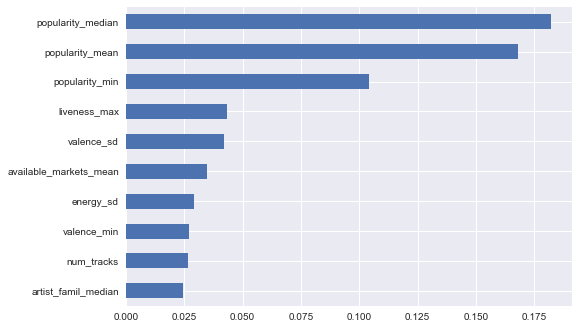

In [156]:
'''This shows similar results for popularity being important'''
feature_importance = pd.Series(clf.best_estimator_.feature_importances_, index = x_train_class.columns)
feature_importance.sort_values(ascending = False).head(10).sort_values(ascending = True).plot('barh')


# Classification Within Categories
## Decision Tree

In [199]:
'''Decision Tree with CV to pick max depth'''
param_grid = {'max_depth' : range(1,30)}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = param_grid, cv = 5, refit = True)
clf.fit(x_train_class, y_train_class_by_cat)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['max_depth']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class_by_cat)*100)[0:5]))

Cross-Validated Max Depth: 2
Avg Cross-Validation Accuracy at Max: 46.10%
Test Accuracy: 46.94%


## Random Forest

In [200]:
'''Random Forest with CV to pick max depth and number of trees'''
param_grid = {'n_estimators' : [2**i for i in [1,2,3,4,5,6,7,8, 9, 10]],
              'max_depth' : [1,2,3,4,5,6,7,8]}
clf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 5, refit = True, n_jobs = 4)
clf.fit(x_train_class, y_train_class_by_cat)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['max_depth']))
print('Cross-Validated Num Trees: {x}'.format(x = clf.best_params_['n_estimators']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class_by_cat)*100)[0:5]))

Cross-Validated Max Depth: 4
Cross-Validated Num Trees: 32
Avg Cross-Validation Accuracy at Max: 48.20%
Test Accuracy: 45.27%


## AdaBoosted Decision Tree

In [194]:
'''AdaBoost with CV to pick max depth and number of trees'''
learning_rate = .05
param_grid = {'n_estimators' : [2**i for i in [1,2,3,4,5,6,7,8]],
              'base_estimator__max_depth' : [1,2,3,4,5,6,7,8, 9, 10, 11, 12]}
clf = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(), learning_rate = learning_rate), param_grid = param_grid, cv = 5, refit = True, n_jobs = 4)
clf.fit(x_train_class, y_train_class_by_cat)
print('Cross-Validated Max Depth: {x}'.format(x = clf.best_params_['base_estimator__max_depth']))
print('Cross-Validated Num Trees: {x}'.format(x = clf.best_params_['n_estimators']))
print('Avg Cross-Validation Accuracy at Max: {x}%'.format(x = str(clf.best_score_*100)[0:5]))
print('Test Accuracy: {x}%'.format(x = str(clf.score(x_test_class,y_test_class_by_cat)*100)[0:5]))

Cross-Validated Max Depth: 1
Cross-Validated Num Trees: 64
Avg Cross-Validation Accuracy at Max: 48.20%
Test Accuracy: 47.77%
